# Telco Customer Churn Analysis, Modeling, and Evaluation

## Step 1: Load and Preview Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve
from torch.utils.data import TensorDataset, DataLoader


In [2]:
# Load data
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2: Data Cleaning

In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
df.drop('customerID', axis=1, inplace=True)

df = pd.get_dummies(df, columns=['MultipleLines'], drop_first=False)

categorical_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,gender_Female,gender_Male,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,False,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,False,True,False,...,False,True,False,False,False,True,False,False,True,False


## Step 3: EDA

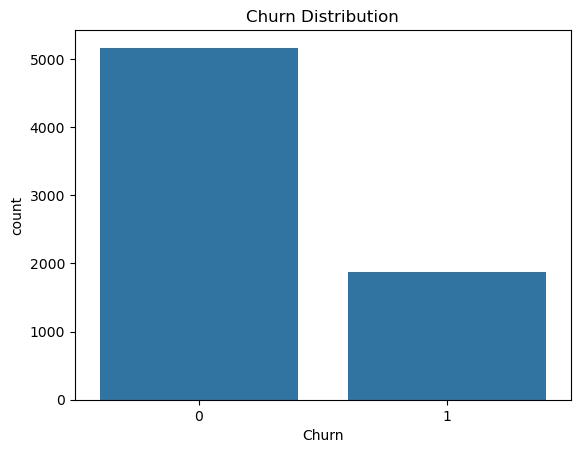

In [4]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

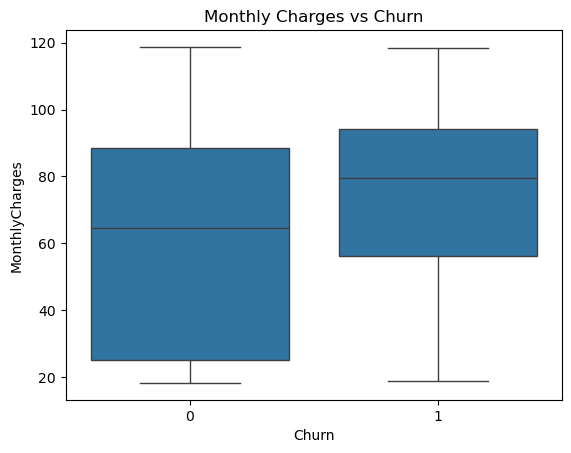

In [5]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

## Step 4: One-Hot Encoding and Scaling

In [6]:
df = pd.get_dummies(df, drop_first=True)


scaler = StandardScaler()
scale_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[scale_cols] = scaler.fit_transform(df[scale_cols])

import joblib
joblib.dump(scaler, "scaler.pkl")


X_columns = df.drop('Churn', axis=1).columns
np.save("model_features.npy", X_columns)

## Step 5: Deep Learning Model Training with GPU Support

In [7]:
X = df.drop('Churn', axis=1).values.astype('float32')
y = df['Churn'].values.astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train).unsqueeze(1)
y_test = torch.tensor(y_test).unsqueeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


class ChurnMLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
                nn.Linear(in_features, 128),   
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.5),

                nn.Linear(128, 64),          
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Dropout(0.5),

                nn.Linear(64, 32),            
                nn.ReLU(),

                nn.Linear(32, 1),         
                nn.Sigmoid()
)

    def forward(self, x):
        return self.net(x)

model = ChurnMLP(X_train.shape[1]).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0001)

losses = []
accuracies = []

for epoch in range(100):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        y_pred = model(xb)
        loss = loss_fn(y_pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = ((y_pred > 0.5) == yb).float().mean()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Average over batches
    losses.append(epoch_loss / len(train_loader))
    accuracies.append(epoch_acc / len(train_loader))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss={losses[-1]:.4f}, Accuracy={accuracies[-1]:.4f}")

Epoch 10: Loss=0.4402, Accuracy=0.7926
Epoch 20: Loss=0.4286, Accuracy=0.7982
Epoch 30: Loss=0.4241, Accuracy=0.7977
Epoch 40: Loss=0.4159, Accuracy=0.8032
Epoch 50: Loss=0.4194, Accuracy=0.8042
Epoch 60: Loss=0.4135, Accuracy=0.8032
Epoch 70: Loss=0.4097, Accuracy=0.8071
Epoch 80: Loss=0.4101, Accuracy=0.8086
Epoch 90: Loss=0.4058, Accuracy=0.8056
Epoch 100: Loss=0.4021, Accuracy=0.8096


In [8]:
torch.save(model.state_dict(), 'customer_churn_model_v1.pt')
print("✅ Model saved to customer_churn_model.pt")

✅ Model saved to customer_churn_model.pt


## Step 6: Training Loss and Accuracy

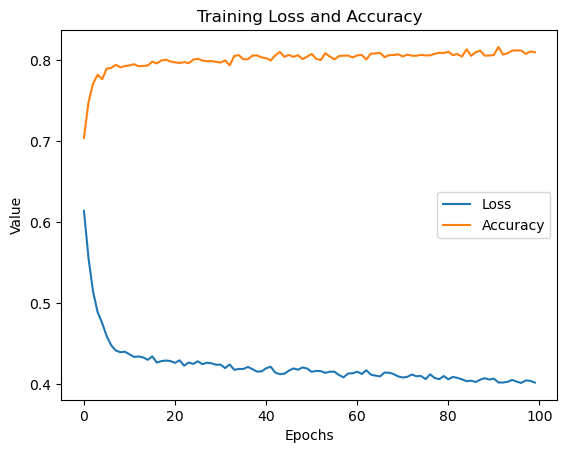

In [9]:
plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

## Step 7: Model Evaluation

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86      1033
         1.0       0.61      0.62      0.61       374

    accuracy                           0.79      1407
   macro avg       0.73      0.74      0.74      1407
weighted avg       0.79      0.79      0.79      1407

ROC AUC Score: 0.8318


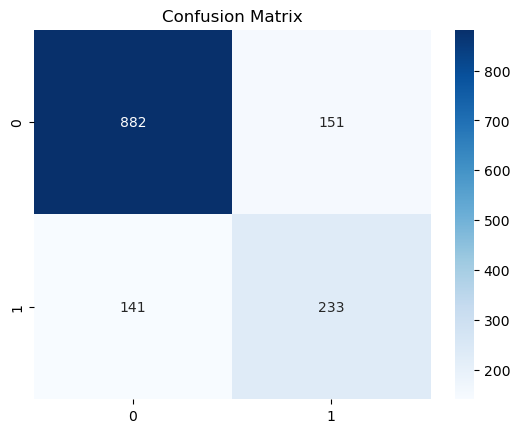

In [10]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred > 0.5).int()
    print('Classification Report:')
    print(classification_report(y_test.cpu().numpy(), y_pred_class.cpu().numpy()))
    print(f"ROC AUC Score: {roc_auc_score(y_test.cpu().numpy(), y_pred.cpu().numpy()):.4f}")
    cm = confusion_matrix(y_test.cpu().numpy(), y_pred_class.cpu().numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()